In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from itertools import product

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.metrics import MAE, MAPE, MASE, RMSE, SMAPE
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import LightningModule
from pytorch_forecasting.data import GroupNormalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

seed_everything(42, workers=True)

Seed set to 42


42

# Load data

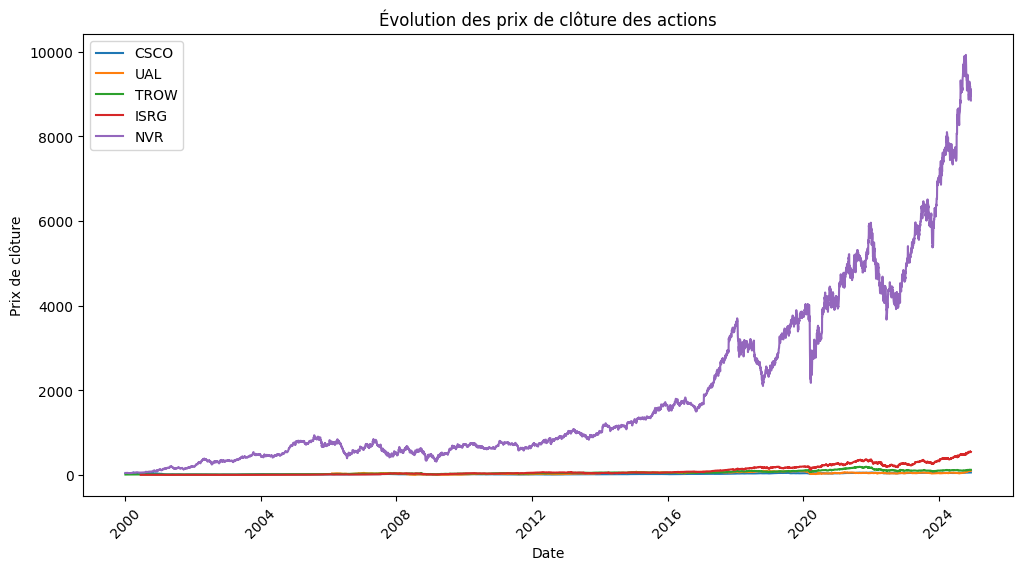

  Unnamed: 0       Date      Close       High        Low       Open    Volume  \
0          0 2000-01-03  35.810463  36.535371  34.319223  36.431813  53076000   
1          1 2000-01-04  33.801411  35.458343  33.718564  34.961263  50805600   
2          2 2000-01-05  33.697857  34.629881  32.227330  33.159354  68524000   
3          3 2000-01-06  33.138645  33.759995  32.682989  33.407897  48242600   
4          4 2000-01-07  35.085533  35.126956  32.931522  32.931522  62260600   

  ticker  SMA        EMA  ...  Daily_Return  Excess_Return  Sharpe_Ratio  \
0   CSCO  NaN  35.810463  ...           NaN            NaN      0.180554   
1   CSCO  NaN  35.619125  ...     -0.056102      -0.056182      0.180554   
2   CSCO  NaN  35.436147  ...     -0.003064      -0.003143      0.180554   
3   CSCO  NaN  35.217337  ...     -0.016595      -0.016674      0.180554   
4   CSCO  NaN  35.204784  ...      0.058750       0.058670      0.180554   

   time_idx  day_of_week  day_of_month  month  year  qua

In [5]:
import os
import pandas as pd
import numpy as np

# Définition du dossier où sont stockés les fichiers extraits
extract_path = "data/stocks"

# Chargement de tous les fichiers CSV dans un DataFrame unique
dfs = []
for file in os.listdir(extract_path):
    if file.endswith(".csv"):
        file_path = os.path.join(extract_path, file)
        ticker = file.replace(".csv", "")  # Suppression de l'extension pour obtenir le ticker
        df = pd.read_csv(file_path, parse_dates=['Date'])  # Charger avec la colonne Date
        
        # Vérification des colonnes essentielles
        required_columns = {"Date", "Close", "High", "Low", "Open", "Volume"}
        if not required_columns.issubset(df.columns):
            print(f"⚠️ {file} ignoré car il manque des colonnes nécessaires")
            continue
        
        # Ajout du ticker comme identifiant
        df['ticker'] = ticker
        
        # Tri des données par date
        df = df.sort_values(by='Date')
        
        # Création de time_idx pour TFT (indice temporel relatif à chaque action)
        df['time_idx'] = np.arange(len(df))
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

        
        # Variables temporelles
        df['day_of_week'] = df['Date'].dt.dayofweek
        df['day_of_month'] = df['Date'].dt.day
        df['month'] = df['Date'].dt.month
        df['year'] = df['Date'].dt.year
        df['quarter'] = df['Date'].dt.quarter
        
        # Stocker le DataFrame
        dfs.append(df)

# Fusionner toutes les actions dans un seul dataset
if dfs:
    df_all = pd.concat(dfs, ignore_index=True)
    
    # Afficher un aperçu du dataset préparé
    import matplotlib.pyplot as plt
    
    # Visualiser l'évolution du prix pour quelques actions
    plt.figure(figsize=(12, 6))
    
    for ticker in df_all['ticker'].unique()[:5]:  # Afficher 5 actions max
        subset = df_all[df_all['ticker'] == ticker]
        plt.plot(subset['Date'], subset['Close'], label=ticker)

    plt.xlabel("Date")
    plt.ylabel("Prix de clôture")
    plt.title("Évolution des prix de clôture des actions")
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

    print(df_all.head())  # Afficher un extrait du DataFrame

else:
    print("❌ Aucun fichier CSV valide trouvé.")


In [14]:
df_all = df_all[df_all['year'] >= 2020]

In [ ]:
import torch
import pytorch_lightning as pl
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.metrics import SMAPE, QuantileLoss
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

class TFTWrapper(pl.LightningModule):
    def __init__(self, tft_model):
        super().__init__()
        self.tft = tft_model

    def forward(self, x):
        return self.tft(x)

    def training_step(self, batch, batch_idx):
        batch = batch[0] if isinstance(batch, tuple) else batch }
        output = self.tft(batch)
        loss = SMAPE()(output["prediction"], batch["decoder_target"])
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        batch = batch[0] if isinstance(batch, tuple) else batch  
        output = self.tft(batch)
        loss = SMAPE()(output["prediction"], batch["decoder_target"])
        self.log("val_loss", loss)
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        batch = batch[0] if isinstance(batch, tuple) else batch  
        return self.tft(batch)["prediction"]

    def configure_optimizers(self):
        return torch.optim.Adam(self.tft.parameters(), lr=1e-3)


In [ ]:
import torch
import pytorch_lightning as pl
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.metrics import SMAPE


max_prediction_length = 30  
max_encoder_length = 60  

df_all.fillna(0.0, inplace=True)
df_all.fillna(0.0, inplace=True)

print(f"✅ NaN restants après correction : {df_all.isna().sum().sum()}")  

num_features = ["Close", "Open", "High", "Low", "Volume", "SMA", "EMA", "MACD", "Signal_Line", "RSI", "CCI", "OBV", "Daily_Return", "Excess_Return", "Sharpe_Ratio"]
static_categoricals = ["ticker"]  

dataset_tft = TimeSeriesDataSet(
    df_all,
    time_idx="time_idx",
    target="Close",
    group_ids=["ticker"],  
    time_varying_known_reals=["day_of_week", "day_of_month", "month", "year", "quarter"],
    time_varying_unknown_reals=num_features,  
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
)

train_dataloader = dataset_tft.to_dataloader(train=True, batch_size=128, num_workers=0)
val_dataloader = dataset_tft.to_dataloader(train=False, batch_size=128, num_workers=0)

tft = TemporalFusionTransformer.from_dataset(
    dataset_tft,
    learning_rate=0.03,
    hidden_size=32,
    attention_head_size=4,
    dropout=0.1,
    output_size=1,  
    loss=SMAPE(),
)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath="checkpoints/",
    filename="model-v{epoch:02d}-v{v_num}",  
    monitor="val_loss",
    save_top_k=1,
    mode="min",
)

trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[checkpoint_callback],
    accelerator="gpu" if torch.cuda.is_available() else "auto",
    devices=1 if torch.cuda.is_available() else "auto",
)

model = TFTWrapper(tft)  
trainer.fit(model, train_dataloader, val_dataloader)


✅ NaN restants après correction : 0


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type                      | Params | Mode 
-----------------------------------------------------------
0 | tft  | TemporalFusionTransformer | 80.9 K | train
-----------------------------------------------------------
80.9 K    Trainable params
0         Non-trainable params
80.9 K    Total params
0.323     Total estimated model params size (MB)
518       Modules in train mode
0         Modules in eval mode


Epoch 6:  91%|█████████ | 4069/4471 [1:33:32<09:14,  0.72it/s, v_num=2]  


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
torch.save(tft, "tft_model.pth")  # Sauvegarder le modèle